In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [35]:
import nltk
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

In [29]:
df = pd.read_csv("./reviews.csv")
sia = SentimentIntensityAnalyzer()

In [13]:
df['content'].values[0]

'smooth Good And better Quality'

In [31]:
test = df['content'][0]
print (test)
tokens = nltk.word_tokenize(test)
nltk.pos_tag(tokens)
sia.polarity_scores(test)

smooth Good And better Quality


{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.7003}

In [36]:
pipe = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [37]:
pipe(test)

[{'label': 'POSITIVE', 'score': 0.999860405921936}]

In [62]:
# Function to analyze sentiment using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment_nltk(text):
    scores = sia.polarity_scores(text)
    return scores

In [61]:
# Function to analyze sentiment using Hugging Face pipeline
def analyze_sentiment_transformer(text):
    test = text[:100]
    result = pipe(test)[0]
    return result

In [63]:
# Apply sentiment analysis to all reviews
nltk_sentiments = df['content'].apply(analyze_sentiment_nltk)
transformer_sentiments = df['content'].apply(analyze_sentiment_transformer)

In [64]:
# Convert the results to separate DataFrames
nltk_df = pd.DataFrame(nltk_sentiments.tolist())
transformer_df = pd.DataFrame(transformer_sentiments.tolist())

In [68]:
# Combine the results with the original DataFrame
df = pd.concat([df, nltk_df, transformer_df], axis=1)
# Save the DataFrame to a new CSV file
df.to_csv('updated_reviews.csv', index=False)

In [66]:
# Display the DataFrame with sentiment scores
print(df.head())


   rating                                            content  \
0     NaN                     smooth Good And better Quality   
1     NaN  Only thing bad is camera quality. Worst image ...   
2     NaN  It’s a great product for the price . Very flui...   
3     NaN                                      Super quality   
4     NaN  Redmi 12 5G (6GB/128GB)\n\nOverview: Having us...   

                                             variant               name  \
0  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...  Salik Ahamad Khan   
1  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...          Darshan P   
2  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...       Yajveer Arya   
3  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...           Srinivas   
4  Colour: Jade BlackSize: 6GB RAM + 128GB Storag...        Placeholder   

                               date  verified sub_reviews    neg    neu  \
0   Reviewed in India on 8 May 2024      True          []  0.000  0.341   
1  Reviewed in

/tmp/ipykernel_30548/1306992470.py:8: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  sns.histplot(df[df['label'] == 'POSITIVE']['score'], bins=20, kde=True, color='green', label='Positive')


ValueError: cannot reindex on an axis with duplicate labels

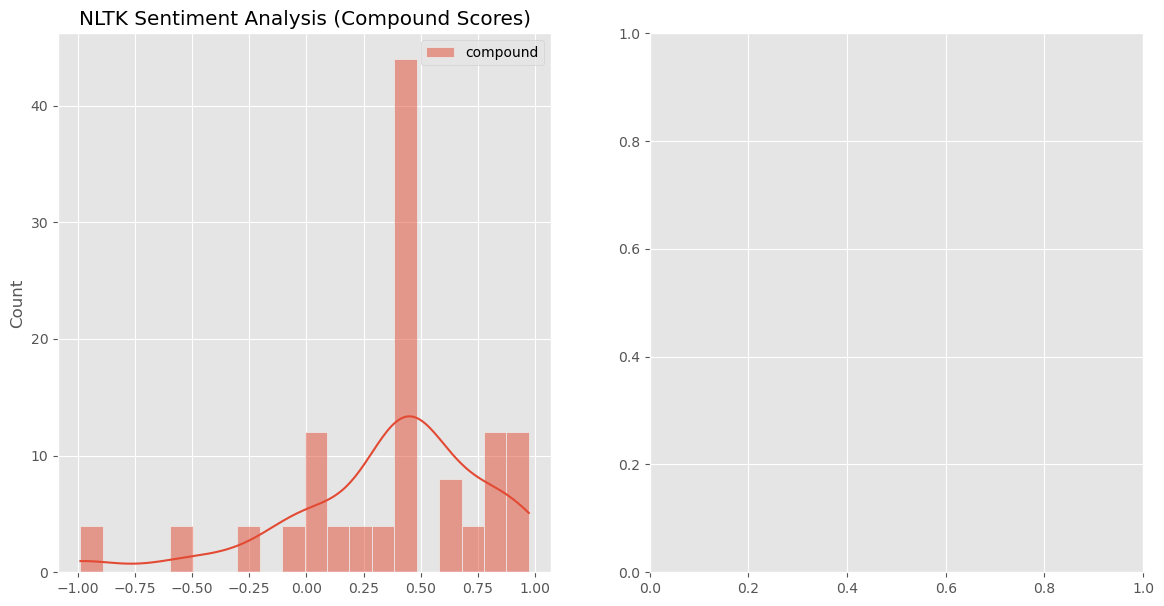

In [67]:
# Visualization of the sentiment analysis results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(df['compound'], bins=20, kde=True, color='blue')
plt.title('NLTK Sentiment Analysis (Compound Scores)')

plt.subplot(1, 2, 2)
sns.histplot(df[df['label'] == 'POSITIVE']['score'], bins=20, kde=True, color='green', label='Positive')
sns.histplot(df[df['label'] == 'NEGATIVE']['score'], bins=20, kde=True, color='red', label='Negative')
plt.title('Transformer Sentiment Analysis (Scores)')
plt.legend()

plt.tight_layout()
plt.show()